In [2]:
import sys
sys.path.append("..")

In [3]:
# %pip install dash

In [4]:
# %pip install UMAP
# %pip install umap
# %pip install --upgrade umap-learn
# %pip install -U kaleido

In [5]:
# %pip install loguru
# %pip install numpy
# %pip install openai
# %pip install plotly

In [6]:
# %pip install nbformat==4.2.0


In [7]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances, cosine_distances
import numpy as np
import logging
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import plotly.express as px
import matplotlib.colors as mcolors
import warnings
import io
from PIL import Image
import nbformat
import IPython
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
from dch_etl.azure_clients.openai_client import OpenAiClient
import plotly.io as pio
from sklearn.metrics import pairwise
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import MinCovDet
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

import nbconvert
import networkx as nx
#from azure.core.credentials import AzureKeyCredential
#from azure.search.documents import SearchClient

## Importar y crear df

In [8]:
import csv

file_path = 'C:\\Users\\55641856\\Desktop\\prep-script\\cluster_centroids.csv'
with open(file_path, "r") as file:
    reader = csv.DictReader(file)
    keys = reader.fieldnames
    results = list(reader)

In [9]:
centroides_df = pd.read_csv(file_path)

# Check if the specified columns exist before selecting them
columns = ['cluster_label', 'centroid', 'etiqueta']
missing_columns = [col for col in columns if col not in centroides_df.columns]

if missing_columns:
    print(f"Warning: The following columns are missing: {missing_columns}")
else:
    centroides_df = centroides_df[columns]


In [10]:
import json

file_path = 'C:\\Users\\55641856\\Desktop\\prep-script\\documentos_pre.json'
with open(file_path, "r") as file:
    results2 = json.load(file)

In [11]:
results2[0].keys()

dict_keys(['document_path', 'ts_file_update', 'category', 'description', 'original_canonic_path', 'content_vector', 'dt_end', 'document_id', 'file_size', 'calendar_name', 'location', 'site_name', 'sp', 'title', 'sheet_name', 'event_id', 'event_name', 'dt_start', 'content', 'etiqueta_cluster', 'event_url', 'ts_creation', 'original_path', 'content_md', 'document_name', 'chunk_id', 'content_type', 'id', 'ts_processed', 'page_number', '@search.score', '@search.reranker_score', '@search.highlights', '@search.captions'])

In [12]:
embeddings_df = pd.DataFrame(results2)[['original_path', "id", "content", "content_type","category", "content_vector", 'document_id', 'chunk_id', 'page_number', 'event_url', 'document_name', 'title', 'description']]

Normalizar los vectores en content_vector

In [13]:
# Función para normalizar un vector
def normalizar_vector(vector):
    norma = np.linalg.norm(vector)
    return vector / norma if norma != 0 else vector

# Aplicar la normalización a cada vector en la columna content_vector
embeddings_df['content_vector_norm'] = embeddings_df['content_vector'].apply(normalizar_vector)

Asignar etiqueta a cada embedding normalizado

In [14]:
# Convertir centroides a un array de numpy, asegurando que son numéricos
centroides = np.array([np.fromstring(c[1:-1], sep=',') for c in centroides_df['centroid'].values])

# # Verifica las dimensiones
# print("Dimensiones de los embeddings:", embeddings_df['content_vector_norm'].iloc[0].shape)
# print("Dimensiones de los centroides:", centroides.shape)

# Función para calcular la distancia Euclidiana
def calcular_distancia(embedding, centroides):
    return np.linalg.norm(centroides - embedding, axis=1)

# Listas para almacenar las etiquetas y los centroides más cercanos
etiquetas_cercanas = []
centroides_cercanos = []

# Iterar sobre cada embedding en embeddings_df
for index, row in embeddings_df.iterrows():
    embedding = row['content_vector_norm']
    distancias = calcular_distancia(embedding, centroides)
    indice_minimo = np.argmin(distancias)
    
    # Agregar la etiqueta y el centroide correspondiente al DataFrame
    etiquetas_cercanas.append(centroides_df['etiqueta'].iloc[indice_minimo])
    centroides_cercanos.append(centroides[indice_minimo])

# Crear nuevas columnas en embeddings_df
embeddings_df['etiqueta_asignada'] = etiquetas_cercanas
embeddings_df['centroide'] = centroides_cercanos



In [20]:
# Contar el número total de 'document_id' y 'chunk_id'
num_document_ids = embeddings_df['document_id'].nunique()
num_chunk_ids = embeddings_df['chunk_id'].count()

print(f"Total de 'document_id': {num_document_ids}")
print(f"Total de 'chunk_id': {num_chunk_ids}")


Total de 'document_id': 1190
Total de 'chunk_id': 5755


Asignamos un color a cada tipo de chunk

In [21]:
color_mapping = {
    'site': '#FFB347',
    'calendar': '#84b6f4',  
    'table': '#77dd77',    
    'document': '#ff6961',      
}
embeddings_df['color'] = embeddings_df['category'].map(color_mapping)

Asignamos un número a cada etiqueta

In [22]:
# Paso 1: Crear un diccionario para asignar números a cada etiqueta
etiquetas_unicas = embeddings_df['etiqueta_asignada'].unique()
etiqueta_dict = {etiqueta: i for i, etiqueta in enumerate(etiquetas_unicas)}

# Paso 2: Crear una nueva columna en el DataFrame
embeddings_df['etiqueta_numero'] = embeddings_df['etiqueta_asignada'].map(etiqueta_dict)

# Repetición: Technique selection

## 1) Sin reducir dimensiones

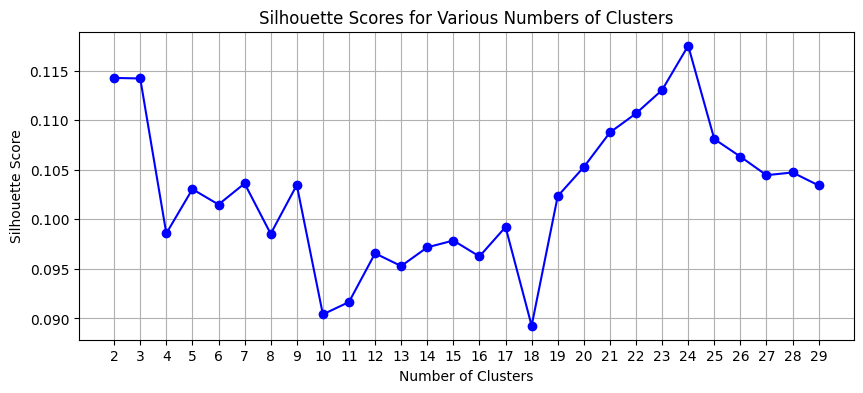

In [43]:
# Generate a line graph for silhouette scores across different numbers of clusters
range_n_clusters = range(2, 30) 
silhouette_avgs = []

# Calculate silhouette scores for different cluster counts
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_avgs.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(10, 4))
plt.plot(range_n_clusters, silhouette_avgs, marker='o', linestyle='-', color='b')
plt.title("Silhouette Scores for Various Numbers of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()


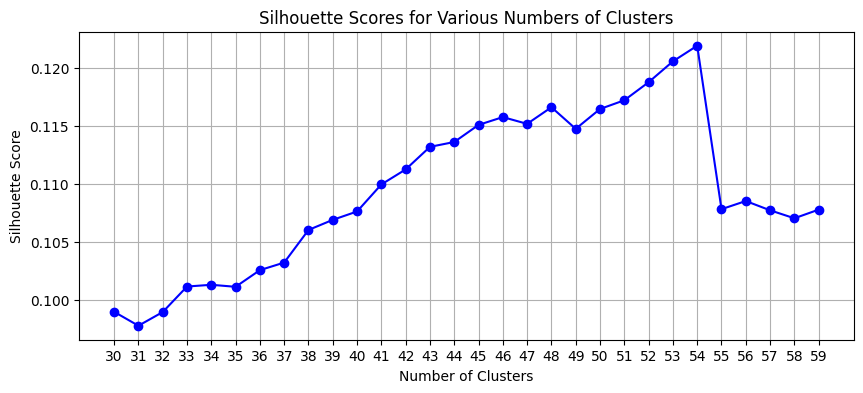

In [45]:
# Generate a line graph for silhouette scores across different numbers of clusters
range_n_clusters = range(30, 60) 
silhouette_avgs = []

# Calculate silhouette scores for different cluster counts
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=123)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_avgs.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(10, 4))
plt.plot(range_n_clusters, silhouette_avgs, marker='o', linestyle='-', color='b')
plt.title("Silhouette Scores for Various Numbers of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()


100 initialiazations per cluster:

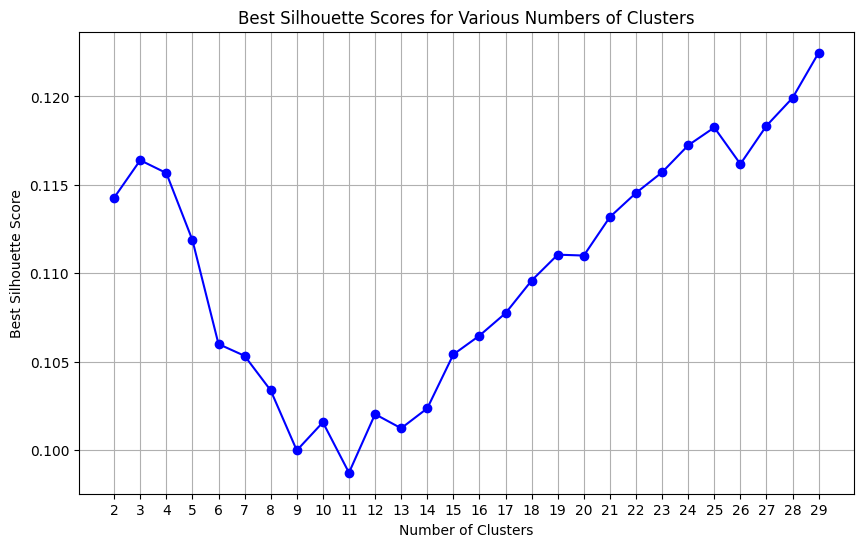

In [47]:
X = np.vstack(embeddings_df['content_vector_norm'].to_numpy())

# Perform 100 calculations per cluster and take the best silhouette score for each cluster count
range_n_clusters = range(2, 30) 
best_silhouette_scores = []

for n_clusters in range_n_clusters:
    best_score = -1  # Initialize with the lowest possible score
    for _ in range(100):  # Perform 100 iterations
        kmeans = KMeans(n_clusters=n_clusters, random_state=None)  # Random seed each time
        cluster_labels = kmeans.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        if silhouette_avg > best_score:
            best_score = silhouette_avg  # Update the best score for this cluster count
    best_silhouette_scores.append(best_score)

# Plot the best silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, best_silhouette_scores, marker='o', linestyle='-', color='b')
plt.title("Best Silhouette Scores for Various Numbers of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Best Silhouette Score")
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()


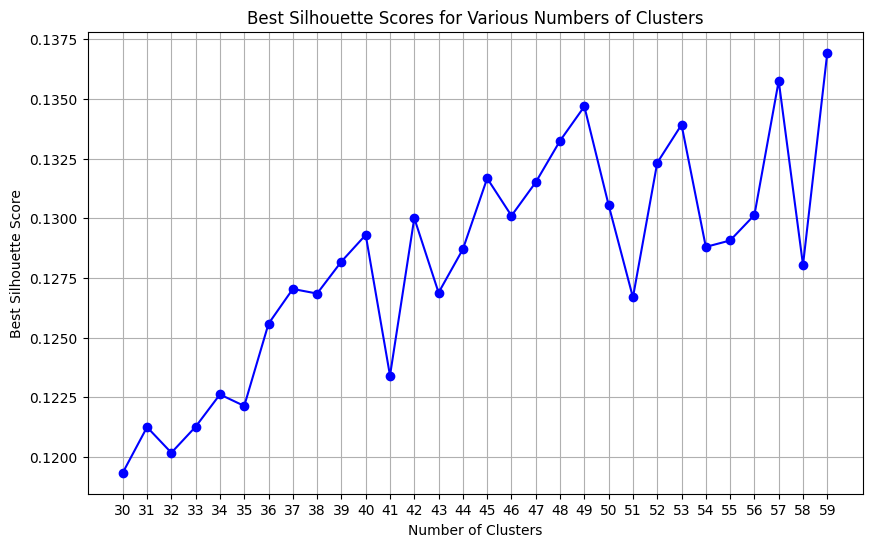

In [24]:
X = np.vstack(embeddings_df['content_vector_norm'].to_numpy())

# Perform 100 calculations per cluster and take the best silhouette score for each cluster count
range_n_clusters = range(30, 60) 
best_silhouette_scores = []

for n_clusters in range_n_clusters:
    best_score = -1  # Initialize with the lowest possible score
    for _ in range(50):  # Perform 10 iterations
        kmeans = KMeans(n_clusters=n_clusters, random_state=None)  # Random seed each time
        cluster_labels = kmeans.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        if silhouette_avg > best_score:
            best_score = silhouette_avg  # Update the best score for this cluster count
    best_silhouette_scores.append(best_score)

# Plot the best silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, best_silhouette_scores, marker='o', linestyle='-', color='b')
plt.title("Best Silhouette Scores for Various Numbers of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Best Silhouette Score")
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()

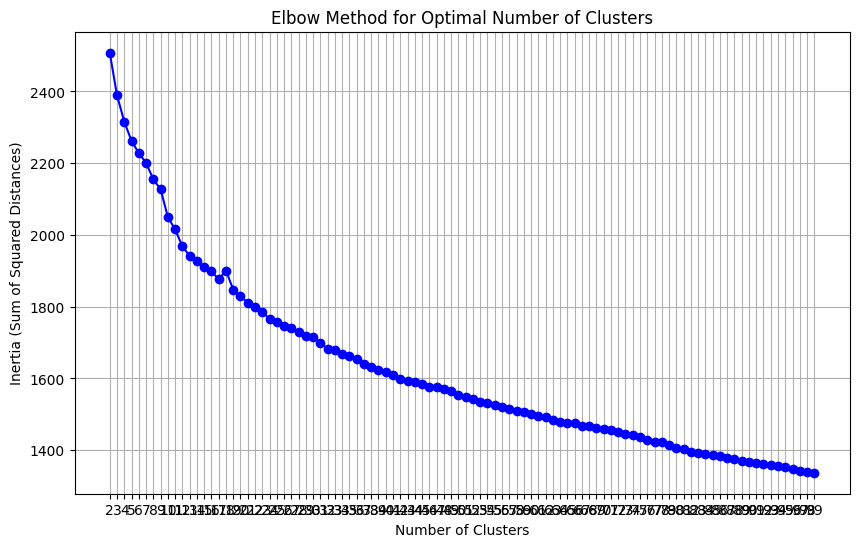

In [53]:
# X = np.vstack(embeddings_df['content_vector_norm'].to_numpy())

# # Define the range for the number of clusters
# range_n_clusters = range(2,100)  # You can increase this range if needed

# # Compute the sum of squared distances (inertia) for each number of clusters
# inertia_values = []
# for n_clusters in range_n_clusters:
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#     kmeans.fit(X)
#     inertia_values.append(kmeans.inertia_)

In [57]:
# def elbow():
#     plt.figure(figsize=(10, 6))
#     plt.plot(range_n_clusters, inertia_values, marker='o', linestyle='-', color='b')
#     plt.title("Elbow Method for Optimal Number of Clusters")
#     plt.xlabel("Number of Clusters (2 to 100)")
#     plt.ylabel("Inertia (Sum of Squared Distances)")
#     #plt.xticks(range_n_clusters)
#     plt.grid(True)
#     plt.show()

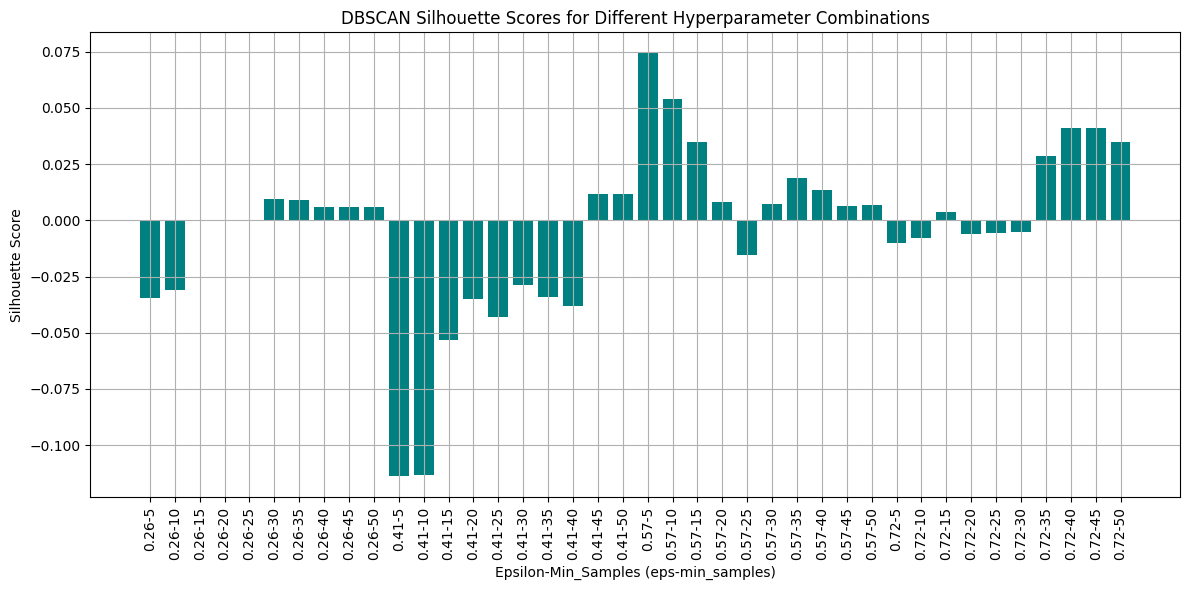

Best DBSCAN Silhouette Score: 0.07424598739045078
Best Epsilon (eps): 0.5666666666666667
Best Min Samples: 5


In [64]:
X = np.vstack(embeddings_df['content_vector_norm'].to_numpy())

# Define hyperparameter ranges for DBSCAN
eps_range = np.linspace(0.1, 1.5, 10)  # Range of epsilon values
min_samples_range = range(5, 55, 5)  # Range of min_samples values (5 to 50, step 5)

# Store results
dbscan_results = []

# Loop through hyperparameter combinations
for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)
        # Check if DBSCAN produced valid clusters
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Exclude noise cluster
        if n_clusters > 1:  # At least 2 clusters are required for a valid silhouette score
            score = silhouette_score(X, labels)
            dbscan_results.append((eps, min_samples, score))

# Check if we have any valid results
if not dbscan_results:
    print("No valid DBSCAN clustering results. Adjust eps or min_samples ranges.")
else:
    # Extract the best hyperparameters
    best_result = max(dbscan_results, key=lambda x: x[2])
    best_eps, best_min_samples, best_score = best_result

    # Prepare data for visualization
    eps_min_samples_labels = [f"{eps:.2f}-{min_samples}" for eps, min_samples, _ in dbscan_results]
    silhouette_scores = [score for _, _, score in dbscan_results]

    # Plot the silhouette scores
    plt.figure(figsize=(12, 6))
    plt.bar(eps_min_samples_labels, silhouette_scores, color='teal')
    plt.title("DBSCAN Silhouette Scores for Different Hyperparameter Combinations")
    plt.xlabel("Epsilon-Min_Samples (eps-min_samples)")
    plt.ylabel("Silhouette Score")
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print the best result
    print(f"Best DBSCAN Silhouette Score: {best_score}")
    print(f"Best Epsilon (eps): {best_eps}")
    print(f"Best Min Samples: {best_min_samples}")

